In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wikipedia
import xml.etree.ElementTree as ET
import re
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10_000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df.head()
df['Plataformas']

0                                   Linux, Windows Server
1                                    Azure, Linux, VMWare
2                              Amazon Web Services, Linux
3                     Amazon Web Services, Windows Server
4       Google Cloud Platform/App Engine, Linux, VMWar...
                              ...                        
5976                                                Linux
5977                                                Azure
5978                    Mainframe, VMWare, Windows Server
5979    Google Cloud Platform/App Engine, Linux, VMWar...
5980                               VMWare, Windows Server
Name: Plataformas, Length: 5766, dtype: object

In [3]:
df_platforms_cols = df['Plataformas'].fillna('').apply(lambda pls: pd.Series([v.lower().strip() for v in pls.split(',') if v.lower().strip() not in ('', 'ninguno')], dtype=str))
count_platforms = pd.concat((df_platforms_cols[i] for i in range(df_platforms_cols.shape[1]))).value_counts()
count_platforms

linux                      2570
windows server             1702
docker                     1630
amazon web services        1471
vmware                      875
                           ... 
oracle pl/sql                 1
software de la empresa        1
exchange y lotus domino       1
ariba cig                     1
tanto                         1
Length: 393, dtype: int64

In [4]:
count_platforms = count_platforms[count_platforms > 10]
count_platforms

linux                               2570
windows server                      1702
docker                              1630
amazon web services                 1471
vmware                               875
azure                                796
kubernetes                           633
google cloud platform/app engine     544
firebase                             354
serverless                           282
openshift                            178
heroku                               176
mainframe                            128
ibm cloud / watson                   119
aix                                  117
openstack                            116
solaris                              101
*bsd                                  78
hp-ux                                 56
sap                                   32
salesforce                            20
dtype: int64

In [5]:
linux = wikipedia.page('Linux', auto_suggest=False)
linux.categories

['1991 software',
 'All Wikipedia articles in need of updating',
 'All articles containing potentially dated statements',
 'Articles containing potentially dated statements from 2014',
 'Articles containing potentially dated statements from 2015',
 'Articles containing potentially dated statements from December 2014',
 'Articles containing potentially dated statements from February 2015',
 'Articles containing potentially dated statements from July 2019',
 'Articles containing potentially dated statements from May 2011',
 'Articles containing potentially dated statements from May 2015',
 'Articles containing potentially dated statements from November 2016',
 'Articles containing potentially dated statements from November 2018',
 'Articles with Curlie links',
 'Articles with hAudio microformats',
 'Articles with short description',
 'Computing platforms',
 'Cross-platform software',
 'Finnish inventions',
 'Free software programmed in C',
 'Linus Torvalds',
 'Linux',
 'Pages including r

In [6]:
def find_categories(platform):
    platform = {
        'azure': 'Microsoft Azure',
        'google cloud platform/app engine': 'Google Cloud Platform',
        'ibm cloud / watson': 'IBM Cloud',
        'aix': 'IBM AIX',
        'solaris': 'Solaris (operating system)',
        '*bsd': 'Berkeley Software Distribution',
        'hp-ux': 'HP-UX',
    }.get(platform, platform)
    # autosuggest redirects linux to line (why?)
    return wikipedia.page(platform, auto_suggest=False).categories
platform_categories = {p: find_categories(p) for p in count_platforms.index}
platform_categories

{'linux': ['1991 software',
  'All Wikipedia articles in need of updating',
  'All articles containing potentially dated statements',
  'Articles containing potentially dated statements from 2014',
  'Articles containing potentially dated statements from 2015',
  'Articles containing potentially dated statements from December 2014',
  'Articles containing potentially dated statements from February 2015',
  'Articles containing potentially dated statements from July 2019',
  'Articles containing potentially dated statements from May 2011',
  'Articles containing potentially dated statements from May 2015',
  'Articles containing potentially dated statements from November 2016',
  'Articles containing potentially dated statements from November 2018',
  'Articles with Curlie links',
  'Articles with hAudio microformats',
  'Articles with short description',
  'Computing platforms',
  'Cross-platform software',
  'Finnish inventions',
  'Free software programmed in C',
  'Linus Torvalds',


In [24]:
catcount = {}
for categories in platform_categories.values():
    for cat in categories:
        catcount[cat] = catcount.get(cat, 0) + 1
catcount = pd.Series(catcount)
catcount = catcount[catcount > 1]
catcount

All articles containing potentially dated statements           4
Articles containing potentially dated statements from 2015     2
Articles with Curlie links                                     3
Articles with short description                               16
Free software programmed in C                                  2
Pages with citations having bare URLs                          2
Pages with citations lacking titles                            2
Webarchive template wayback links                              5
Wikipedia articles with GND identifiers                        3
Wikipedia articles with LCCN identifiers                       3
Wikipedia articles with VIAF identifiers                       2
All articles lacking reliable references                       2
All articles with unsourced statements                        13
Commons category link from Wikidata                            5
Cloud computing providers                                      8
Cloud infrastructure     

In [25]:
df_platforms = pd.DataFrame({plat: {cat: cat in cats for cat in catcount.index} for plat, cats in platform_categories.items()}).T
df_platforms.head()

,All articles containing potentially dated statements,Articles containing potentially dated statements from 2015,Articles with Curlie links,Articles with short description,Free software programmed in C,Pages with citations having bare URLs,Pages with citations lacking titles,Webarchive template wayback links,Wikipedia articles with GND identifiers,Wikipedia articles with LCCN identifiers,...,Google Cloud,Web services,All articles with a promotional tone,Serverless computing,Companies based in San Francisco,Salesforce.com,All articles needing additional references,CS1 maint: multiple names: authors list,UNIX System V,Articles with unsourced statements from June 2020
linux,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
windows server,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
docker,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
amazon web services,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
vmware,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


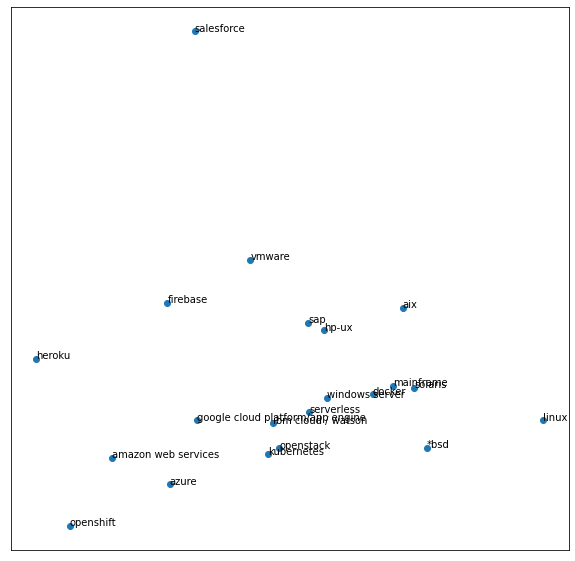

In [26]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
df_embedded = PCA(n_components=2).fit_transform(df_platforms)
ax.scatter(df_embedded[:, 0], df_embedded[:, 1])
for lang, (x, y) in zip(df_platforms.index, df_embedded):
    ax.annotate(lang, (x, y))
ax.set_xticks([]);
ax.set_yticks([]);

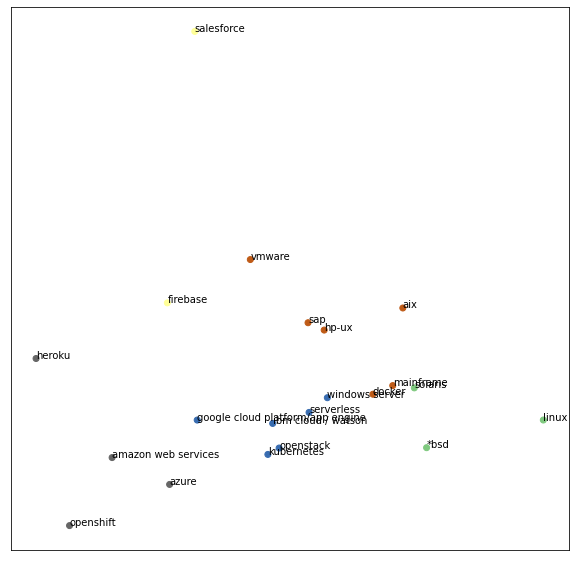

In [28]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=7, assign_labels="discretize", random_state=0).fit(df_embedded)
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(df_embedded[:, 0], df_embedded[:, 1], c=clustering.labels_, cmap='Accent')
for plat, (x, y) in zip(df_platforms.index, df_embedded):
    ax.annotate(plat, (x, y))
ax.set_xticks([]);
ax.set_yticks([]);

In [11]:
best = {'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.025, 'max_depth': 16, 'min_child_weight': 15.0, 'n_estimators': 175, 'subsample': 0.8099576733552297}
regions_map = {
    'Ciudad Autónoma de Buenos Aires': 'AMBA',
    'GBA': 'AMBA',
    'Catamarca': 'NOA',
    'Chaco': 'NEA',
    'Chubut': 'Patagonia',
    'Corrientes': 'NEA',
    'Entre Ríos': 'NEA',
    'Formosa': 'NEA',
    'Jujuy': 'NOA',
    'La Pampa': 'Pampa',
    'La Rioja': 'NOA',
    'Mendoza': 'Cuyo',
    'Misiones': 'NEA',
    'Neuquén': 'Patagonia',
    'Río Negro': 'Patagonia',
    'Salta': 'NOA',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',
    'Santa Cruz': 'Patagonia',
    'Santa Fe': 'Pampa',
    'Santiago del Estero': 'NOA',
    'Tucumán': 'NOA',
    'Córdoba': 'Pampa',
    'Provincia de Buenos Aires': 'Pampa',
    'Tierra del Fuego': 'Patagonia',
}
class BaseModel:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Lenguajes de programación',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
cross_val_score(BaseModel(), df, df['Salario mensual BRUTO (en tu moneda local)'])

array([0.49657124, 0.35863404, 0.54711517, 0.4280007 , 0.47291457])

In [29]:
platform_embeddings = {l: [] for l in clustering.labels_}
for platform, label in zip(df_platforms.index, clustering.labels_):
    platform_embeddings[label].append(platform)
platform_embeddings

{0: ['linux', 'solaris', '*bsd'],
 3: ['windows server',
  'kubernetes',
  'google cloud platform/app engine',
  'serverless',
  'ibm cloud / watson',
  'openstack'],
 4: ['docker', 'vmware', 'mainframe', 'aix', 'hp-ux', 'sap'],
 5: ['amazon web services', 'azure', 'openshift', 'heroku'],
 2: ['firebase', 'salesforce']}

In [30]:
class ModelPCA:
    def __init__(self, **params):
        self.regressor_ = xgb.XGBRegressor(**params)

    def get_params(self, deep=True):
        return self.regressor_.get_params(deep=deep)

    def set_params(self, **params):
        return self.regressor_.set_params(**params)
    
    def clean_words(self, field, value):
        value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
        value = value.replace('Snacks, golosinas, bebidas', 'snacks')
        value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
        value = value.replace('Sí, de forma particular', 'de forma particular')
        value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
        value = value.replace('Sí, activa', 'activa')
        value = value.replace('Sí, pasiva', 'pasiva')
        return [self.clean_word(field, v) for v in value.split(',') if self.clean_word(field, v)]

    def clean_word(self, field, word):
        val = str(word).lower().strip().replace(".", "")
        if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
            return ''
        if field == 'Lenguajes de programación' and val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
            return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('pycon', 'pyconar'):
            return 'pyconar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('nodeconf', 'nodeconfar'):
            return 'nodeconfar'
        if field == '¿A qué eventos de tecnología asististe en el último año?' and val in ('meetup', 'meetups'):
            return 'meetups'
        if field == '¿A qué eventos de tecnología asististe en el último año?':
            return val.replace(' ', '')
        if field == 'Beneficios extra' and val == 'snacks':
            return 'snacks, golosinas, bebidas'
        if field == 'Beneficios extra' and val == 'descuentos varios':
            return 'descuentos varios (clarín 365, club la nación, etc)'
        return val

    def contains_platform(self, row, platforms):
        k = 'Plataformas'
        for v in self.clean_words(k, row.fillna('')[k]):
            if v in platforms:
                return True
        return False

    def row_to_words(self, row):
        return [
            f'{key}={row.fillna("")[key]}'
            for key
            in (
                'Me identifico',
                'Nivel de estudios alcanzado',
                'Universidad',
                'Estado',
                'Carrera',
                '¿Contribuís a proyectos open source?',
                '¿Programás como hobbie?',
                'Trabajo de',
                '¿Qué SO usás en tu laptop/PC para trabajar?',
                '¿Y en tu celular?',
                'Tipo de contrato',
                'Orientación sexual',
                'Cantidad de empleados',
                'Actividad principal',
            )
        ] + [
            f'{k}={v}' for k in (
                '¿Tenés guardias?',
                'Realizaste cursos de especialización',
                '¿A qué eventos de tecnología asististe en el último año?',
                'Beneficios extra',
                'Plataformas',
                'Frameworks, herramientas y librerías',
                'Bases de datos',
                'QA / Testing',
                'IDEs',
                'Lenguajes de programación'
            ) for v in self.clean_words(k, row.fillna('')[k])
        ] + [
            f'region={regions_map[row["Dónde estás trabajando"]]}'
        ] + [
            f'platform_type={i}'
            for i, platforms in platform_embeddings.items()
            if self.contains_platform(row, platforms)
        ]

    def encode_row(self, row):
        ws = self.row_to_words(row)
        return pd.Series([w in ws for w in self.valid_words_] + [
            row['¿Gente a cargo?'],
            row['Años de experiencia'],
            row['Tengo'],
        ])

    def fit(self, X, y, **params):
        counts = {}
        for i in range(X.shape[0]):
            for word in self.row_to_words(X.iloc[i]):
                counts[word] = counts.get(word, 0) + 1
        self.valid_words_ = [word for word, c in counts.items() if c > 0.01*X.shape[0]]
        self.regressor_.fit(X.apply(self.encode_row, axis=1).astype(float), y, **params)
        return self
   
    def predict(self, X):
        return self.regressor_.predict(X.apply(self.encode_row, axis=1).astype(float))
    
    def score(self, X, y):
        return r2_score(y, self.predict(X))
cross_val_score(ModelPCA(), df, df['Salario mensual BRUTO (en tu moneda local)'])

array([0.49439315, 0.36750751, 0.56335836, 0.451916  , 0.44273419])